# Vit Transformer

![alt text](https://drive.google.com/uc?export=view&id=1J5TvycDPs8pzfvlXvtO5MCFBy64yp9Fa)

In [12]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 2.8 MB/s eta 0:00:00


In [137]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

import random
from tqdm.auto import tqdm
from torch import nn
from torch import Tensor
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from PIL import Image
import torchvision
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

import matplotlib.pyplot as plt

![](https://amaarora.github.io/images/vit-01.png)

## Часть 1. Patch Embedding, CLS Token, Position Encoding

![](https://amaarora.github.io/images/vit-02.png)

In [14]:
# input image `B, C, H, W`
x = torch.randn(1, 3, 224, 224)
# 2D conv
conv = nn.Conv2d(3, 768, 16, 16)
conv(x).reshape(-1, 196).transpose(0,1).shape

torch.Size([196, 768])

In [15]:
class PatchEmbedding(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()

        self.conv = nn.Conv2d(in_chans, embed_dim, patch_size, patch_size)
        self.num_patches = (img_size // patch_size) ** 2

    def forward(self, image):
        patch_embeddings = self.conv(image).flatten(2).transpose(1, 2)
        
        return patch_embeddings

In [16]:
patch_embed = PatchEmbedding()
x = torch.randn(2, 3, 224, 224)
patch_embed(x).shape 

torch.Size([2, 196, 768])

![](https://amaarora.github.io/images/vit-03.png)

## Часть 2. Transformer Encoder

![](https://amaarora.github.io/images/ViT.png)

![](https://amaarora.github.io/images/vit-07.png)

In [78]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0.):
        super().__init__()
        if hidden_features is None:
            hidden_features = in_features * 4
        if out_features is None:
            out_features = in_features

        # Linear Layers
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, out_features)

        # Activation(s)
        self.elu = nn.ELU()
        self.dropout = nn.Dropout(drop)

    def forward(self, x):
        x = self.dropout(self.elu(self.fc1(x)))
        x = self.elu(self.fc2(x))

        return x

In [20]:
x = torch.randn(1, 197,768)
mlp = MLP(768, 3072, 768)
out = mlp(x)
out.shape

torch.Size([1, 197, 768])

In [60]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., out_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.out = nn.Linear(dim, dim)
        self.out_drop = nn.Dropout(out_drop)

    def forward(self, x):
        batch_size, seq_length, dim = x.shape

        # Attention
        qkv_output = self.qkv(x)
        qkv_output = qkv_output.reshape(
            batch_size,
            seq_length,
            3,
            self.num_heads,
            dim // self.num_heads,
        )

        # qkv_output[batch, seq_pos, q/k/v, head_num, attn_dim]
        q = qkv_output[:, :, 0, :, :].transpose(1, 2)
        k = qkv_output[:, :, 1, :, :].transpose(1, 2)
        v = qkv_output[:, :, 2, :, :].transpose(1, 2)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        v_attn = attn @ v

        # Out projection
        out_proj = self.out(v_attn.reshape(batch_size, seq_length, dim))
        out_proj = self.out_drop(out_proj)

        return out_proj


![](https://amaarora.github.io/images/vit-08.png)

In [ ]:
# attn = (q @ k.transpose(-2, -1)) * self.scale
# attn = attn.softmax(dim=-1)

In [61]:
x = torch.randn(1, 197, 768)
attention = Attention(768, 12)
out = attention(x)
out.shape

torch.Size([1, 197, 768])

In [75]:
from torch.nn.modules.normalization import LayerNorm

class Block(nn.Module):
    def __init__(self, dim, num_heads=8, mlp_ratio=4, drop_rate=0.):
        super().__init__()

        # Normalization
        self.norm1 = LayerNorm([dim])

        # Attention
        self.attention = Attention(
            dim,
            num_heads,
            attn_drop=drop_rate,
            out_drop=drop_rate,
        )

        # Normalization
        self.norm2 = LayerNorm([dim])

        # MLP
        self.mlp = MLP(
            in_features=dim,
            hidden_features=int(dim*mlp_ratio),
            out_features=dim,
            drop=drop_rate,
        )
                

    def forward(self, x):
        # Attetnion
        x_attn = self.attention(self.norm1(x))
        x_attn = x_attn + x

        # MLP
        x_mlp = self.mlp(self.norm2(x))
        x_mlp = x_mlp + x_attn

        return x_mlp

In [64]:
x = torch.randn(2, 197, 768)
block = Block(768, 8)
out = attention(x)
out.shape

torch.Size([2, 197, 768])

В оригинальной реализации теперь используется [DropPath](https://github.com/rwightman/pytorch-image-models/blob/e98c93264cde1657b188f974dc928b9d73303b18/timm/layers/drop.py)

In [65]:
class Transformer(nn.Module):
    def __init__(self, depth, dim, num_heads=8, mlp_ratio=4, drop_rate=0.):
        super().__init__()
        self.blocks = nn.ModuleList([
            Block(dim, num_heads, mlp_ratio, drop_rate)
            for i in range(depth)])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

In [67]:
x = torch.randn(4, 197, 768)
block = Transformer(12, 768)
out = attention(x)
out.shape

torch.Size([4, 197, 768])

![](https://amaarora.github.io/images/vit-06.png)

In [81]:
class ViT(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4., 
                 qkv_bias=False, drop_rate=0.,):
        super().__init__()

        # Присвоение переменных

        # Path Embeddings, CLS Token, Position Encoding
        self.patch_embed = PatchEmbedding(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
        )
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(
            1, self.patch_embed.num_patches + 1, embed_dim
        ))


        # Transformer Encoder
        self.transformer = Transformer(
            depth=depth,
            dim=embed_dim,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio,
            drop_rate=drop_rate,
        )

        # Classifier
        self.classifier = nn.Linear(768, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]
      
        # Path Embeddings, CLS Token, Position Encoding
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed

        # Transformer Encoder
        x = self.transformer(x)

        # Classifier
        x = self.classifier(x[:, 0])

        return x

In [83]:
x = torch.randn(2, 3, 224, 224)
vit = ViT()
out = vit(x)
out.shape

torch.Size([2, 1000])

# Домашнее задание


1. Выбрать датасет для классификации изображений с размерностью 64x64+ 
2. Обучить ViT на таком датасете.
3. Попробовать поменять размерности и посмотреть, что поменяется при обучении.


Примечание:
- Датасеты можно взять [тут](https://pytorch.org/vision/stable/datasets.html#built-in-datasets) или найти в другом месте.
- Из за того, что ViT учится медленно, количество примеров в датасете можно ограничить до 1к-5к.

In [87]:
!mkdir data

In [98]:
dataset = torchvision.datasets.Food101(
    root='data',
    split='train',
    download=True,
)

  0%|          | 0/4996278331 [00:00<?, ?it/s]

Extracting data/food-101.tar.gz to data


In [105]:
print(f'Dataset size: {len(dataset)}')

Dataset size: 75750


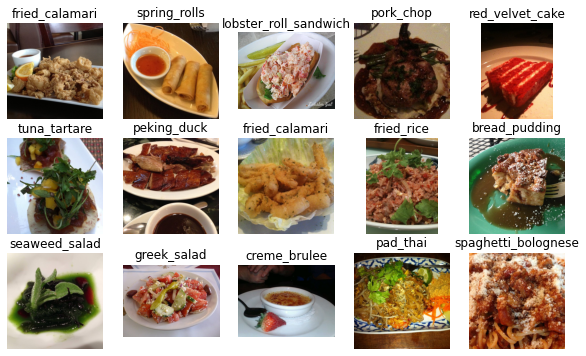

In [112]:
rows = 3
cols = 5
plt.figure(figsize=(10, 6))

for i in range(rows * cols):
    image, class_idx = dataset[random.randint(0, len(dataset)-1)]
    class_name = dataset.classes[class_idx]

    plt.subplot(rows, cols, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(class_name)

In [145]:
dataset = torchvision.datasets.Food101(
    root='data',
    split='train',
    download=True,
    transform=Compose([
        Resize((224, 224)),
        ToTensor(),
    ])
)
dataset = random_split(dataset, (0.1, 0.9))[0]
print(f'Reduced dataset size: {len(dataset)}')

loader = DataLoader(dataset, batch_size=8, shuffle=True)

Reduced dataset size: 7575


In [134]:
def train(model, loss, optimizer, loader, device: str='cpu', num_epochs: int=1):
    model.train()
    loss_history = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0

        for x, y in tqdm(loader, desc=f'Epoch {epoch+1}'):
            x, y = x.to(device), y.to(device)

            output = model(x)
            batch_loss = loss(output, y)

            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            epoch_loss += batch_loss.item()
        
        epoch_loss /= len(loader)
        loss_history.append(epoch_loss)

        print(f'Loss: {epoch_loss}')

    return loss_history

In [135]:
device = 'cuda'

model = ViT().to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [146]:
loss_history = train(
    model,
    loss,
    optimizer,
    loader,
    device,
    num_epochs=10,
) 

Epoch 1:   0%|          | 0/947 [00:00<?, ?it/s]

Loss: 5.924452201617683


Epoch 2:   0%|          | 0/947 [00:00<?, ?it/s]

Loss: 5.461229804199122


Epoch 3:   0%|          | 0/947 [00:00<?, ?it/s]

Loss: 4.955891478527436


Epoch 4:   0%|          | 0/947 [00:00<?, ?it/s]

Loss: 4.786420315346723


Epoch 5:   0%|          | 0/947 [00:00<?, ?it/s]

Loss: 4.716018365076502


Epoch 6:   0%|          | 0/947 [00:00<?, ?it/s]

Loss: 4.586631353452818


Epoch 7:   0%|          | 0/947 [00:00<?, ?it/s]

Loss: 4.478706869933019


Epoch 8:   0%|          | 0/947 [00:00<?, ?it/s]

Loss: 4.43037234339568


Epoch 9:   0%|          | 0/947 [00:00<?, ?it/s]

Loss: 4.3628137776315405


Epoch 10:   0%|          | 0/947 [00:00<?, ?it/s]

Loss: 4.279638960343857
